# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Import data

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [7]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//Fezf2_thymus_paper/scVI_models/combined_all_genes/model.pt already  
         downloaded                                                                                                


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
# cellxgene epithelial cells
cell_x_gene_exprs = np.load(f"{processedDataPath}cell_x_gene_atlas/expression/cell_x_gene_atlas_expression.npy")
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
cells = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/obs_names.csv")['0']
metadata = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/cell_metadata.csv", index_col=0)
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs, columns=genes)
cell_x_gene_exprs["cell_type"] = metadata.cell_type.values
cell_x_gene_exprs = cell_x_gene_exprs[cell_x_gene_exprs.cell_type.str.contains("epithelial")]
del cell_x_gene_exprs["cell_type"]
adata = adata[:, adata.var_names.isin(cell_x_gene_exprs.columns)].copy()
cell_x_gene_exprs = cell_x_gene_exprs[adata.var_names].copy()

# scVI num genes expressed

## pick threshold

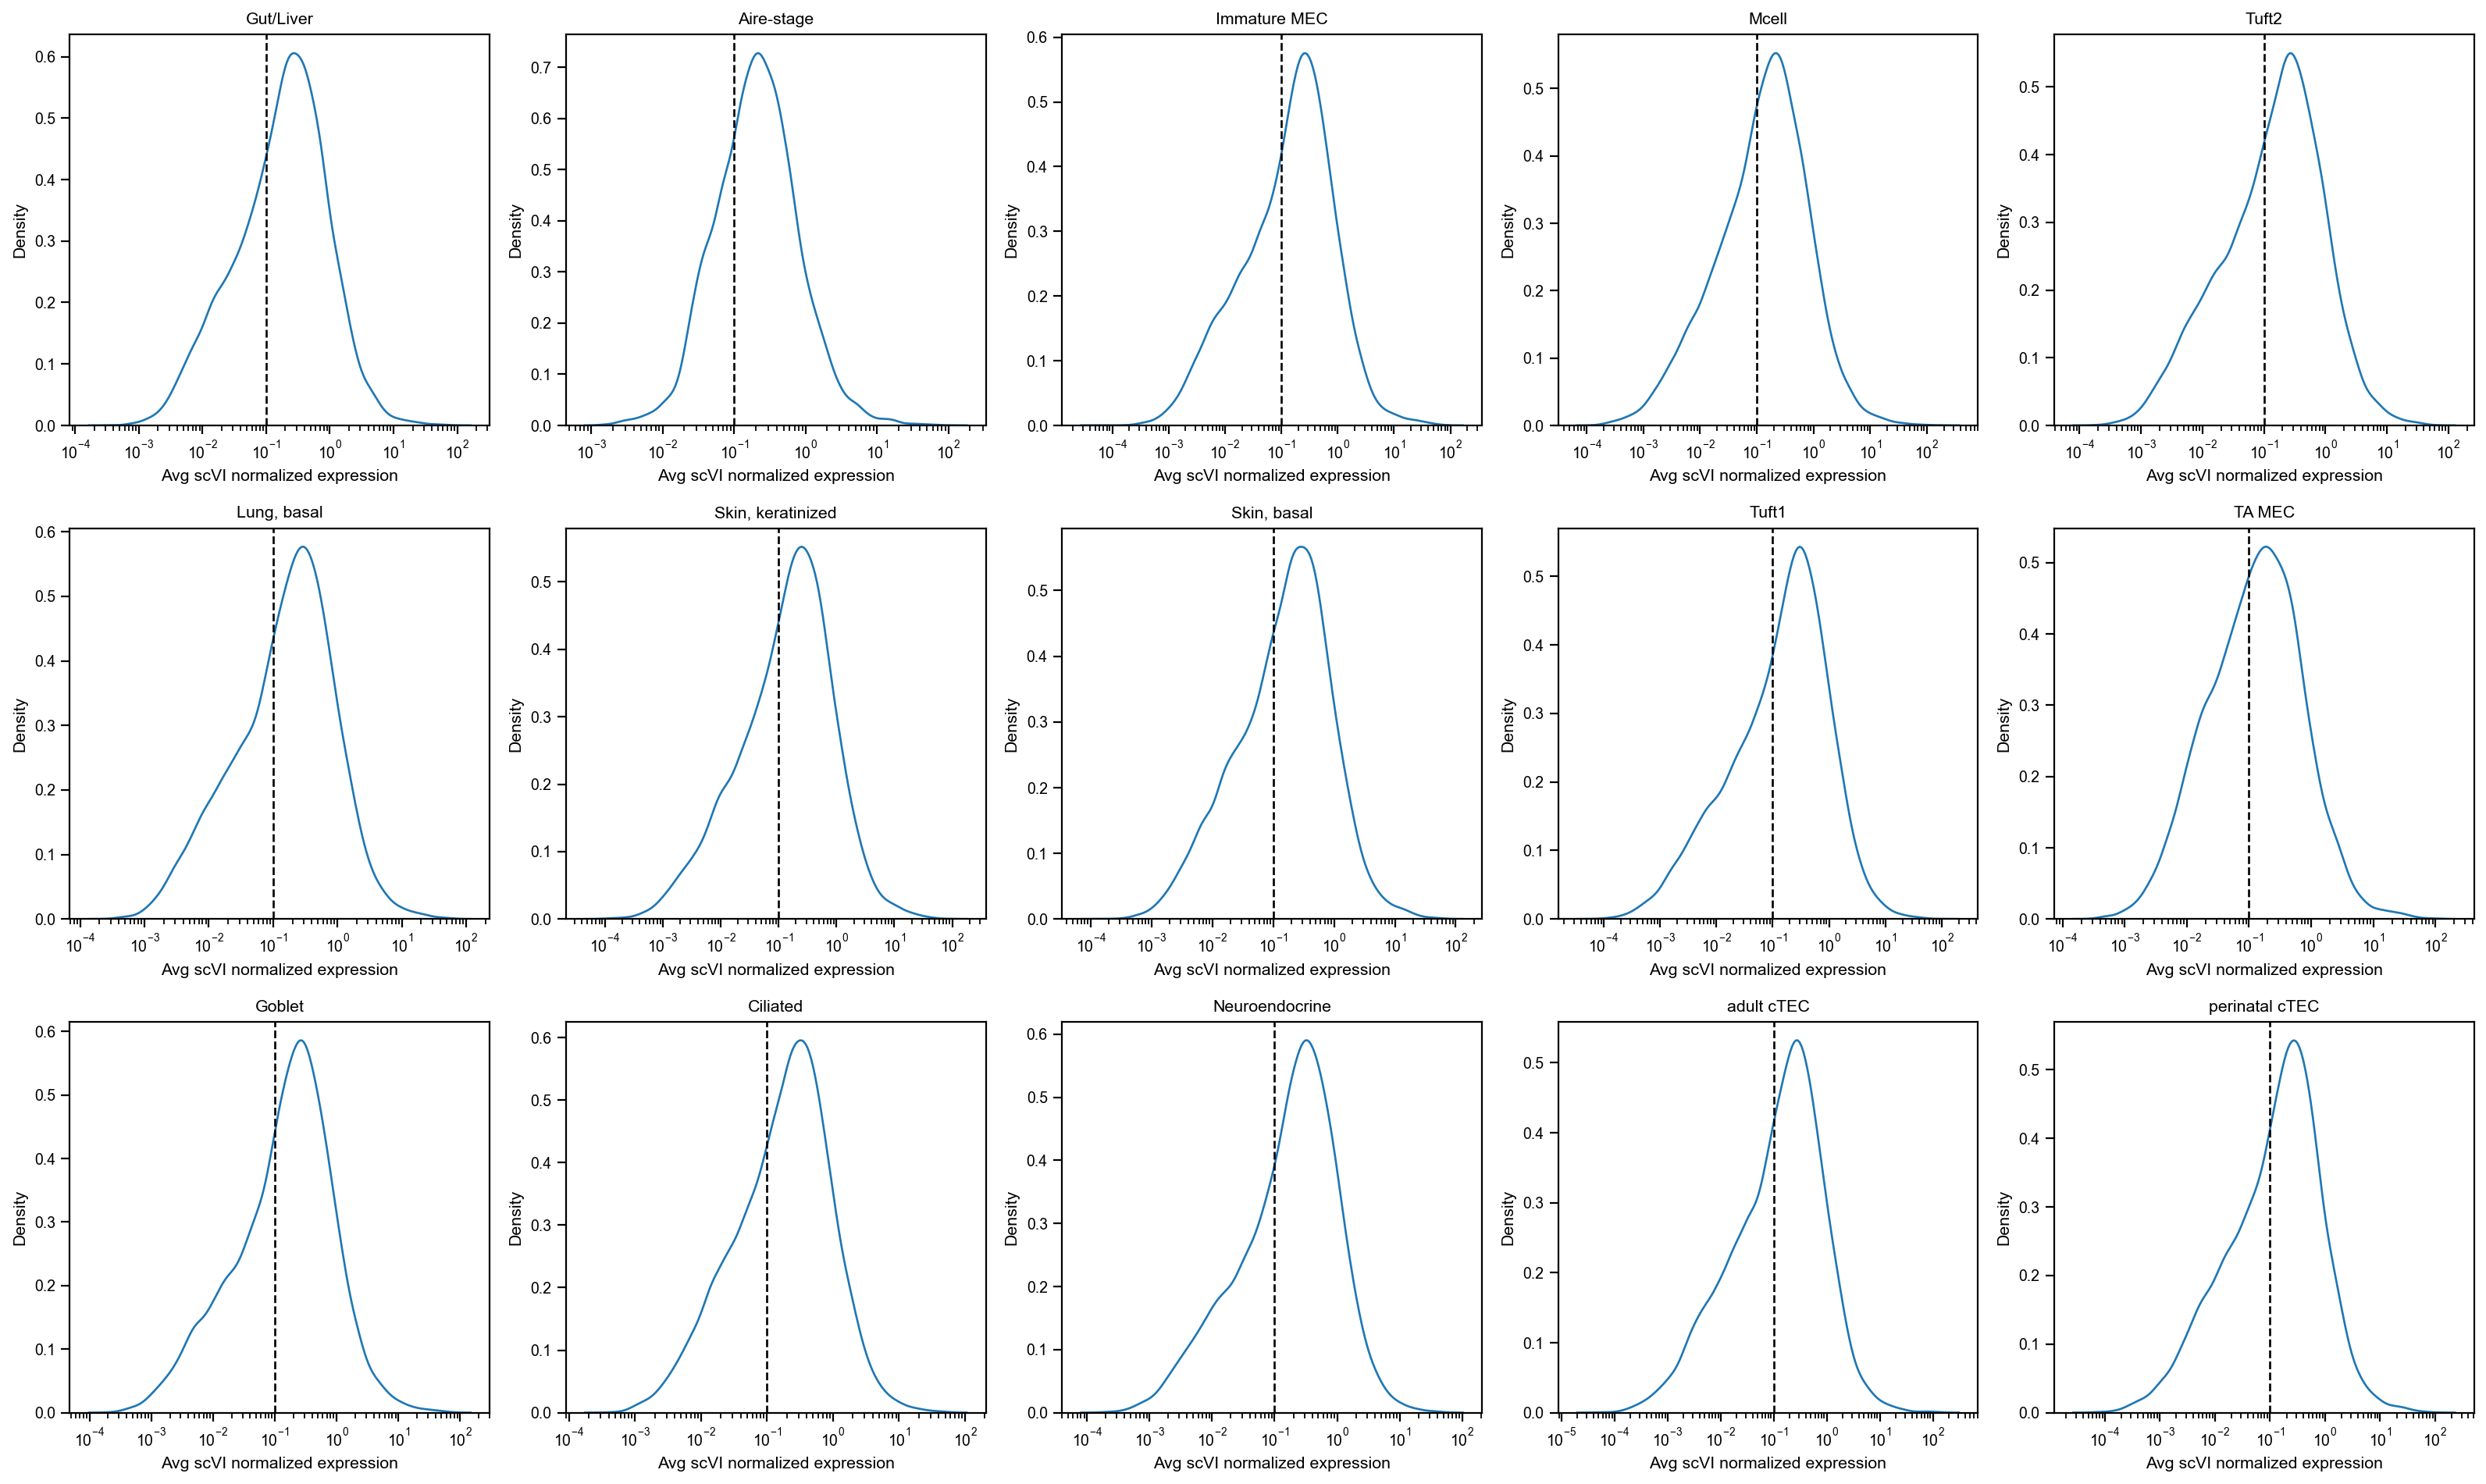

In [9]:
ncols = 5
nrows = math.ceil(len(adata.obs.majority_voting.unique())/ncols)
plt.figure(figsize=(4*ncols, 4*nrows))
for i,cell_type in enumerate(adata.obs.majority_voting.unique()):
    data = rna.tl.get_expression_matrix(
        adata[(adata.obs.genotype == "WT") & (adata.obs.majority_voting == cell_type)],
        gene_data="scVI_normalized"
    ).mean(axis=0)
    plt.subplot(nrows, ncols, i+1)
    ax = sns.kdeplot(data, log_scale=True)
    ax.set_title(cell_type)
    ax.set_xlabel("Avg scVI normalized expression")
    plt.axvline(x=0.1, color="black", linestyle="--")
plt.tight_layout()
plt.show()

## plot num genes by genotype and cluster

In [ ]:
exprs = rna.tl.get_expression_matrix(
    adata, 
    gene_data="scVI_normalized"
)
exprs = exprs > 0.1
exprs = pd.DataFrame(exprs.sum(axis=1))
exprs["cell_type"] = adata.obs.majority_voting
exprs["genotype"] = adata.obs.genotype

plt.figure(figsize=(13,4))
sns.violinplot(
    exprs,
    x="cell_type",
    y=0,
    hue="genotype",
    scale='width',
    width=0.75,
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
    palette=cmap[0:2] + [cmap[4]],
    order=["perinatal cTEC", "adult cTEC", "Immature MEC", "TA MEC", "Aire-stage", "Lung, basal",
           "Skin, basal", "Skin, keratinized", "Mcell", "Neuroendocrine", "Goblet",
           "Gut/Liver", "Ciliated", "Tuft1", "Tuft2"]
)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.ylim(1000, 17000)
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/S3/S3A_num_genes_expressed.pdf")
plt.show()

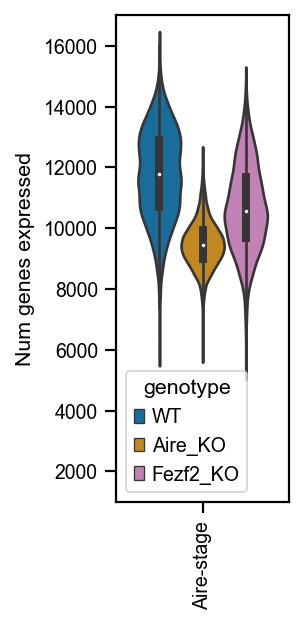

In [20]:
exprs = rna.tl.get_expression_matrix(
    adata[adata.obs.majority_voting == "Aire-stage"], 
    gene_data="scVI_normalized"
)
exprs = exprs > 0.1
exprs = pd.DataFrame(exprs.sum(axis=1))
exprs["cell_type"] = adata.obs.majority_voting
exprs.cell_type = exprs.cell_type.cat.remove_unused_categories()
exprs["genotype"] = adata.obs.genotype

plt.figure(figsize=(2,4))
sns.violinplot(
    exprs,
    x="cell_type",
    y=0,
    hue="genotype",
    scale='width',
    width=0.75,
    palette=cmap[0:2] + [cmap[4]],
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.ylim(1000, 17000)
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/2/2A_Aire-stage_num_genes_expressed.pdf")
plt.show()

# Raw data validation

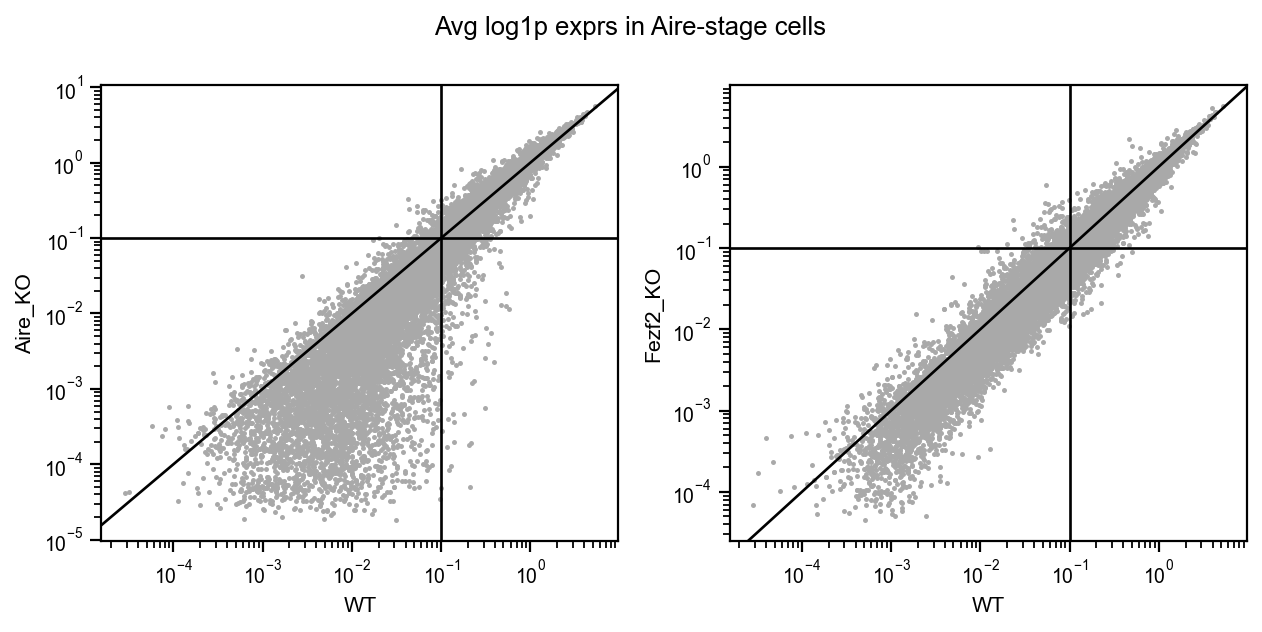

In [25]:
exprs = rna.tl.get_expression_matrix(
    adata[adata.obs.majority_voting == "Aire-stage"],
    gene_data="log1p",
)
exprs["genotype"] = adata.obs.genotype
exprs = exprs.groupby("genotype").mean()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.scatterplot(exprs.T, x="WT", y="Aire_KO", s=5, c="darkgrey", linewidth=0) 
plt.axline([0,0], slope=1, c="black")
plt.axhline(y=0.1, c="black")
plt.axvline(x=0.1, c="black")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
sns.scatterplot(exprs.T, x="WT", y="Fezf2_KO", s=5, c="darkgrey", linewidth=0) 
plt.axline([0,0], slope=1, c="black")
plt.axhline(y=0.1, c="black")
plt.axvline(x=0.1, c="black")
plt.xscale("log")
plt.yscale("log")

plt.suptitle("Avg log1p exprs in Aire-stage cells")
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/2/2B_avg_log1p_Aire-stage_expression.pdf")
plt.show()

# Cell x gene epithelial cells

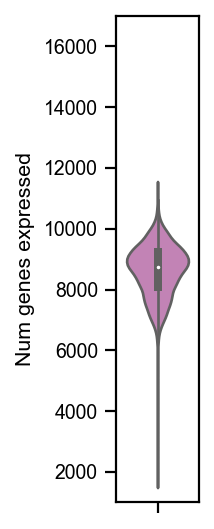

In [13]:
cell_x_gene_num_genes = cell_x_gene_exprs >= 0.1
cell_x_gene_num_genes["num_genes"] = cell_x_gene_num_genes.sum(axis=1)

plt.figure(figsize=(0.66,4))
sns.violinplot(
    cell_x_gene_num_genes,
    y="num_genes",
    scale='width',
    width=0.75,
    palette=[cmap[2]],
)
plt.ylim(1000, 17000)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.savefig("../../analysis/paper_figures/S3/S3A_cell_x_gene_num_genes_expressed.pdf")
plt.show()